In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

import anndata2ri
import rpy2
from rpy2.robjects import r


anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [3]:
organoid_gex = sc.read('../../fetal_lung/Roche/new_20230705/gut_scpoli_integration.h5ad')

In [4]:
organoid_gex

AnnData object with n_obs × n_vars = 806646 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2', 'level_3', 'sort_batch', 'Cell_type', 'n_counts', 'batch', 'publication', 'sample_name', 'tissue', 'derive', 'detail_tissue', 'time', 'time2', 'main_cells', 'protocol', 'tech', 'tech_detail', 'molecular', 'gel', 'leiden', 'leiden_10.0', 'level_1_late', 'level_2_late', 'level_3_late'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scPoli', 'X_umap', 'X_umap_min', 'X_umap_sc'
    layers: 'ambiguous', 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

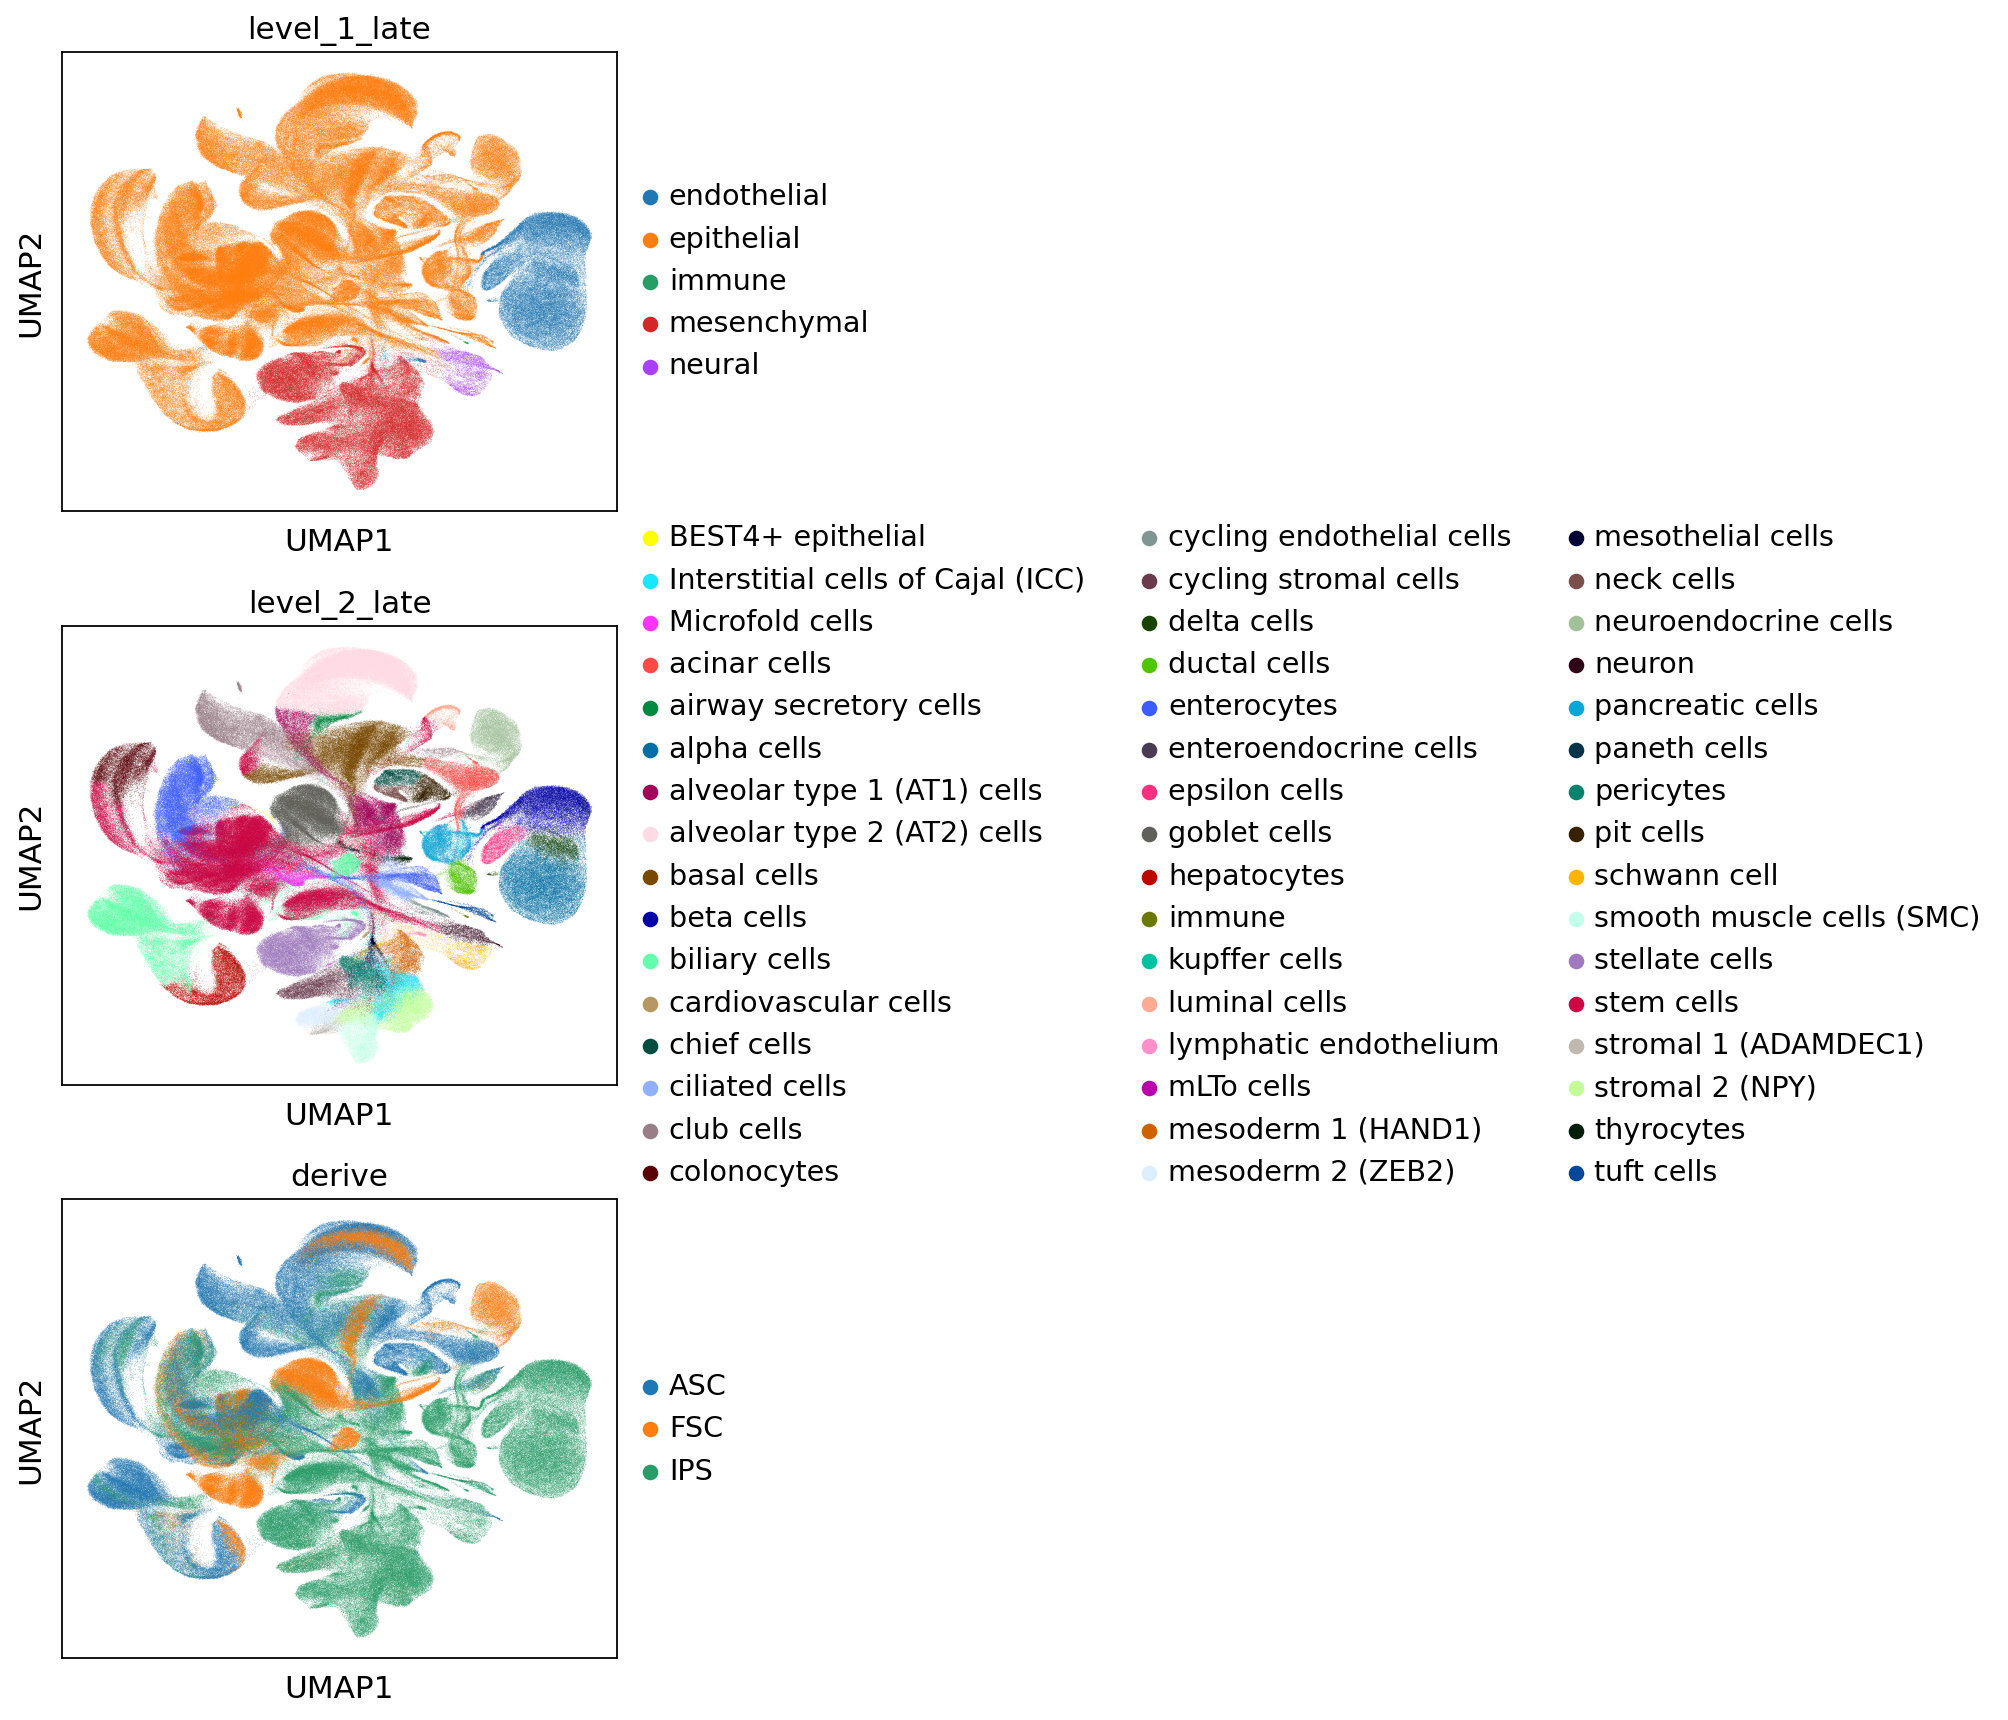

In [5]:
sc.pl.umap(organoid_gex, color = ['level_1_late','level_2_late', 'derive'], ncols=1)

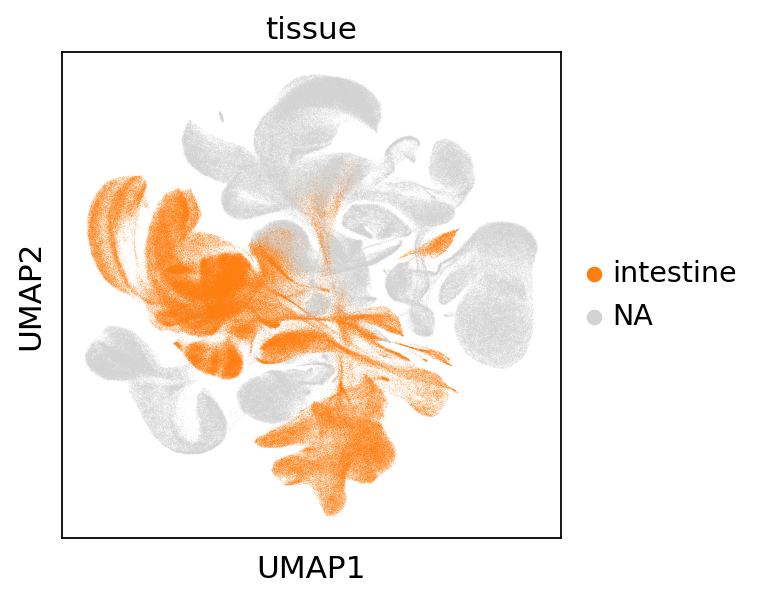

In [6]:
sc.pl.umap(organoid_gex, color = ['tissue'], groups=['intestine'], ncols=1)

In [7]:
organoid_gex = organoid_gex[organoid_gex.obs.tissue.isin(['intestine'])].copy()

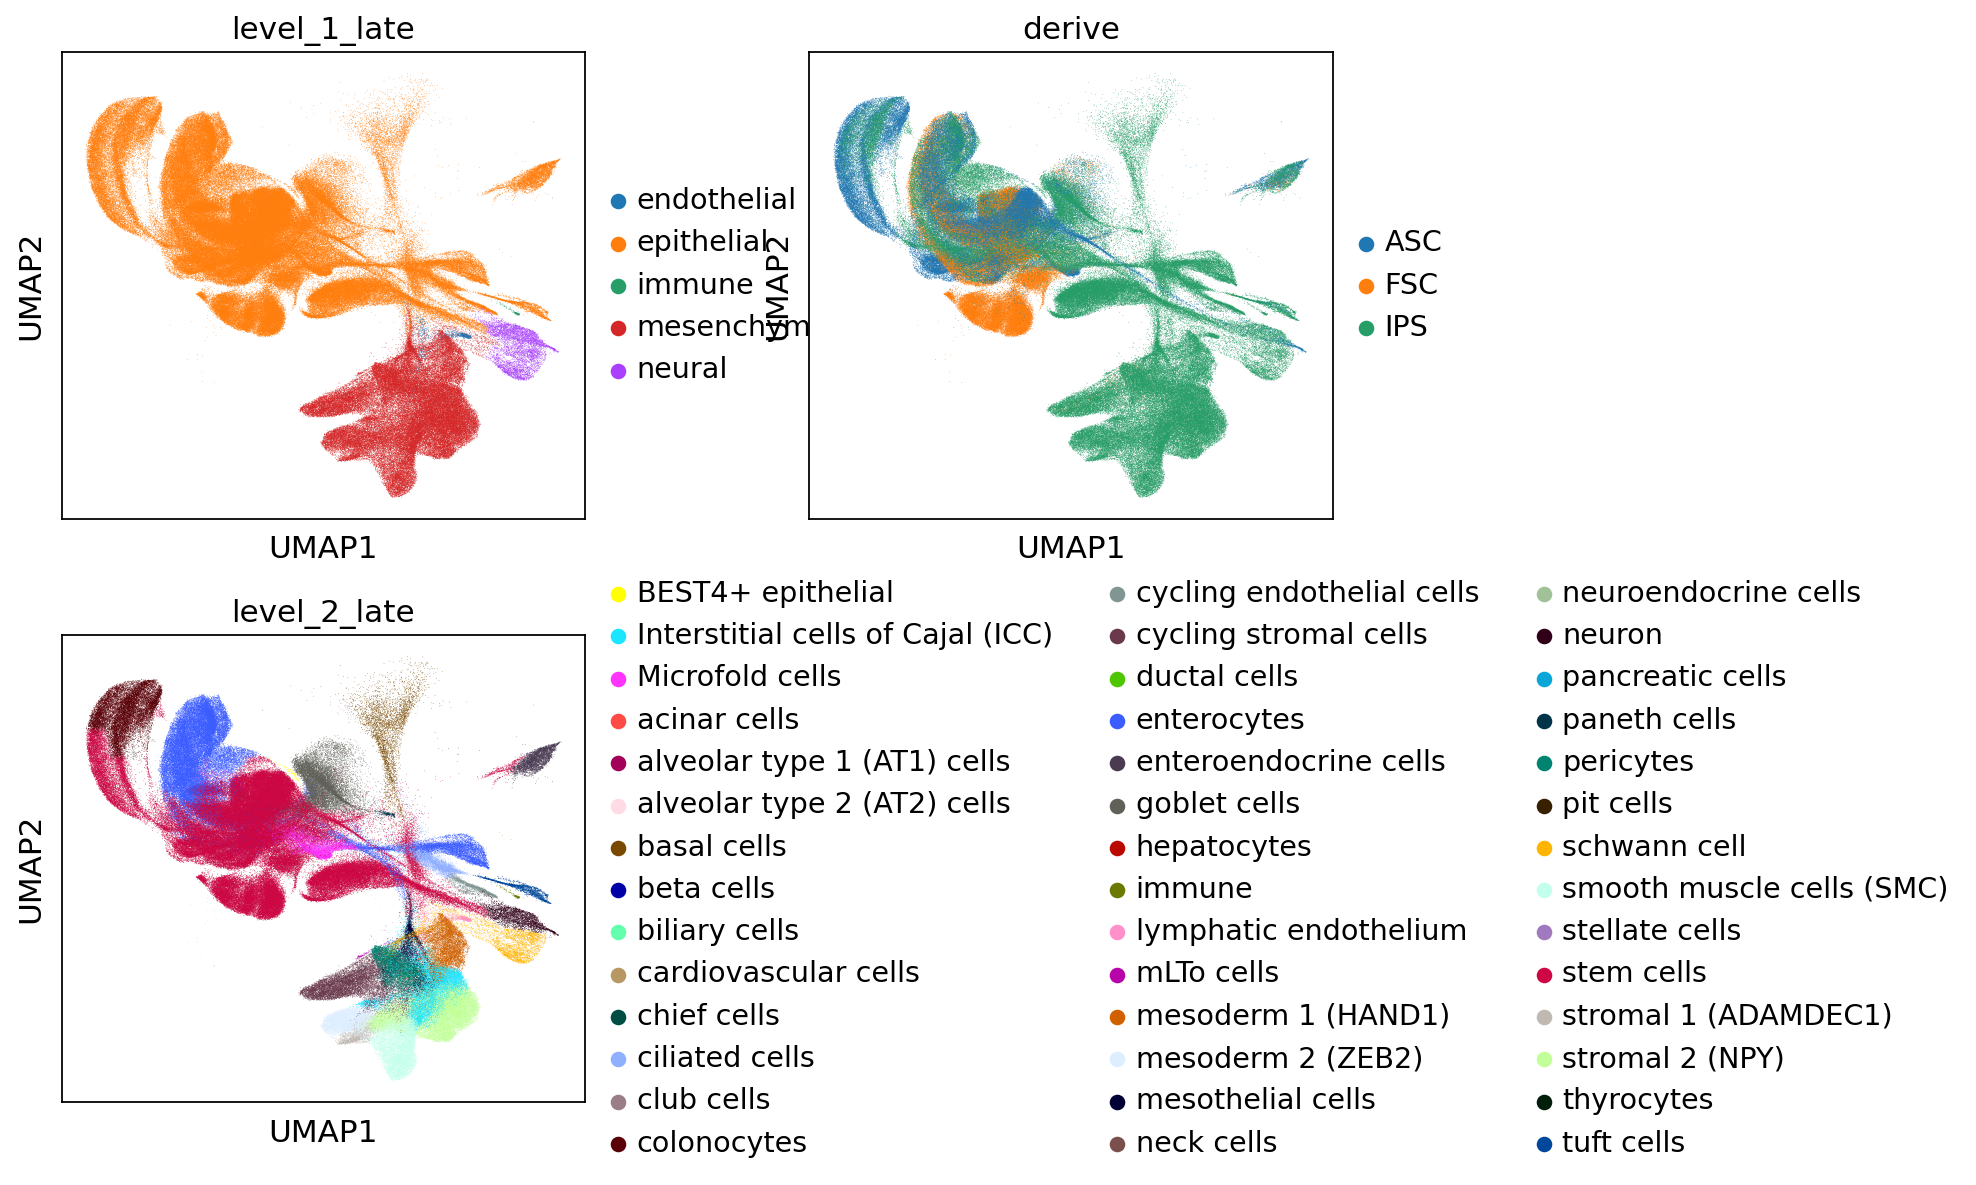

In [8]:
sc.pl.umap(organoid_gex, color = ['level_1_late','derive','level_2_late'], ncols=2, wspace = 0.3)

In [9]:
organoid_gex.obs.level_1_late.value_counts()

epithelial     267791
mesenchymal     78062
neural           6136
endothelial      1014
immune            137
Name: level_1_late, dtype: int64

In [10]:
tissue_latent = sc.read('../../fetal_lung/Roche/intestine_fetal_adult_atlas/adata_latent_source.h5ad')

In [11]:
# map colors
col_map = pd.read_table('gut_scpoli_color.txt', header=None, index_col=0)
col_map = dict(zip(col_map.index, col_map[1]))
tissue_latent.uns['Cell_type_colors'] = tissue_latent.obs.Cell_type.cat.categories.map(col_map).tolist()

In [12]:
%%R -i organoid_gex
organoid_gex

class: SingleCellExperiment 
dim: 2000 353140 
metadata(9): hvg leiden ... derive_colors tissue_colors
assays(5): X ambiguous counts spliced unspliced
rownames(2000): ADAMTS9-AS2 BHLHE40-AS1 ... ZNF804A ZWINT
rowData names(6): highly_variable means ... highly_variable_nbatches
  highly_variable_intersection
colnames(353140): AAAACCGAAACA-0-0-0-17 AAAACCTTTAGT-0-0-0-17 ...
  TTTGTTGTCGTGACTA.1-207 TTTGTTGTCTGTGTGA.1-207
colData names(38): initial_size_spliced initial_size_unspliced ...
  level_2_late level_3_late
reducedDimNames(4): X_scPoli UMAP X_umap_min X_umap_sc
altExpNames(0):


### Compute Neighborhoods 

### Tissue

In [13]:
%%R
library(miloR)
library(scrabbitr)

Loading required package: edgeR
Loading required package: limma

Attaching package: ‘limma’

The following object is masked from ‘package:BiocGenerics’:

    plotMA


Attaching package: ‘edgeR’

The following object is masked from ‘package:SingleCellExperiment’:

    cpm

Loading required package: ggplot2
Loading required package: data.table
data.table 1.14.8 using 4 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following object is masked from ‘package:SummarizedExperiment’:

    shift

The following object is masked from ‘package:GenomicRanges’:

    shift

The following object is masked from ‘package:IRanges’:

    shift

The following objects are masked from ‘package:S4Vectors’:

    first, second

Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
 

In [14]:
%%R
suppressPackageStartupMessages(library(ggraph))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(viridis))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(jsonlite))
suppressPackageStartupMessages(library(ggrastr))
suppressPackageStartupMessages(library(ggridges))
suppressPackageStartupMessages(library(ggalluvial))
suppressPackageStartupMessages(library(ggrepel))

In [15]:
%%R 
t_milo <- readRDS("compare_nhoods/intestine_analysis/t_milo.rds")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


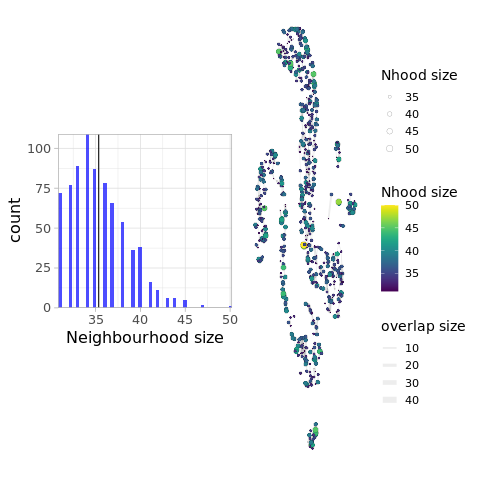

In [16]:
%%R

options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 300)

p1 <- scrabbitr::plotNhoodSizeHist(t_milo, colour="blue")
#ggsave("../plots/compare_nhoods/r_milo_nhood_size_hist.pdf", p1, width=4, height=4, dpi=300)

p2 <- plotNhoodGraph(t_milo, size_range=c(0.1,3), node_stroke=0.1) + 
scale_fill_viridis(name = "Nhood size", option = "viridis", direction = 1) 
#ggsave("../plots/compare_nhoods/r_nhood_size_graph.pdf", p2, width=6, height=5, dpi=300)

grid.arrange(p1, p2, nrow=1)

### Organoid

In [17]:
%%R
# Compute organoid neighbourhoods - FSC
o_milo <- Milo(organoid_gex[,organoid_gex$derive == 'FSC'])
o_milo <- buildGraph(o_milo, k=30, d=2, reduced.dim="UMAP")
o_milo <- makeNhoods(o_milo, prop=0.05, k=30, d=2,refined=T, reduced_dims="UMAP")

Constructing kNN graph with k:30
Checking valid object
Running refined sampling with reduced_dim
In addition: Warning message:
In (function (to_check, X, clust_centers, clust_info, dtype, nn,  :
  detected tied distances to neighbors, see ?'BiocNeighbors-ties'


In [18]:
%%R
o_milo <- buildNhoodGraph(o_milo)

In [19]:
%%R
# # Export miloR object
# writeMM(o_milo@nhoods,"compare_nhoods/all_organoid_analyses/o_fsc_nhoods.mtx")
# saveRDS(o_milo,"compare_nhoods/all_organoid_analyses/o_fsc_milo.rds")

NULL


In [20]:
%%R
# o_milo = readRDS("compare_nhoods/all_organoid_analyses/o_fsc_milo.rds")

NULL


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


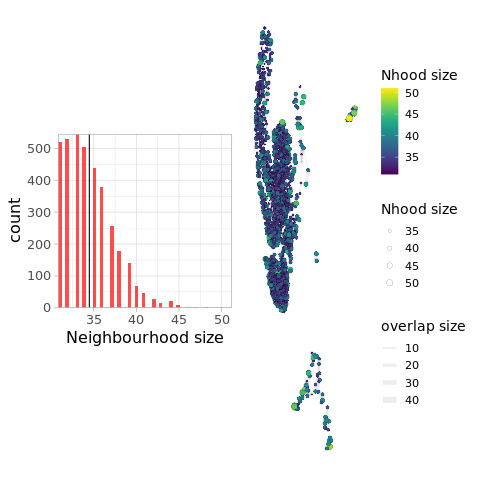

In [21]:
%%R
# Plot nhoods and size distribution
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 300)

p3 <- plotNhoodSizeHist(o_milo, colour="red")
#ggsave("../plots/compare_nhoods/m_milo_nhood_size_hist.pdf", p3, width=4, height=4, dpi=300)

p4 <- plotNhoodGraph(o_milo,size_range=c(0.1,3) ,node_stroke=0.1) + 
scale_fill_viridis(name = "Nhood size", option = "viridis", direction=1)
#ggsave("../plots/compare_nhoods/m_nhood_size_graph.pdf", p4, width=6, height=5, dpi=300)

grid.arrange(p3, p4, nrow = 1)

In [22]:
%%R
o_milo

class: Milo 
dim: 2000 76220 
metadata(9): hvg leiden ... derive_colors tissue_colors
assays(5): X ambiguous counts spliced unspliced
rownames(2000): ADAMTS9-AS2 BHLHE40-AS1 ... ZNF804A ZWINT
rowData names(6): highly_variable means ... highly_variable_nbatches
  highly_variable_intersection
colnames(76220): AAACCTGAGATGTGTA-36 AAACCTGAGCTGCGAA-36 ...
  TTTGGTTTCGATAACC-63 TTTGGTTTCTACGGGC-63
colData names(38): initial_size_spliced initial_size_unspliced ...
  level_2_late level_3_late
reducedDimNames(4): X_scPoli UMAP X_umap_min X_umap_sc
altExpNames(0):
nhoods dimensions(2): 76220 3686
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(1): graph
nhoodIndex names(1): 3686
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 3686 3686


In [23]:
%%R
t_milo

class: Milo 
dim: 3000 15773 
metadata(2): hvg log1p
assays(3): X counts logcounts
rownames(3000): A1BG A4GALT ... ZXDC ZZEF1
rowData names(18): gene_ids.0 feature_types.0 ...
  highly_variable_nbatches highly_variable_intersection
colnames(15773): S1_AAACCTGGTCTCATCC_fetal-0
  S1_AAACCTGGTGCCTGGT_fetal-0 ... TTTGTTGAGCTCGACC-1-2-1
  TTTGTTGCATGCCGGT-1-2-1
colData names(16): sample_id Age ... n_genes tissue
reducedDimNames(1): UMAP
altExpNames(0):
nhoods dimensions(2): 15773 753
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(1): graph
nhoodIndex names(1): 753
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 753 753


In [24]:
%%R
assay(o_milo, "logcounts") <- assays(o_milo)[['X']]

In [25]:
%%R
# saveRDS(o_milo,"compare_nhoods/all_organoid_analyses/o_milo_fsc_incl_logcounts.rds")

NULL


In [26]:
%%R
# o_milo = readRDS("compare_nhoods/all_organoid_analyses/o_milo_fsc_incl_logcounts.rds")

NULL


In [27]:
%%R
assay(o_milo, "logcounts")[1:50,1:10]

50 x 10 sparse Matrix of class "dgCMatrix"
                                                                      
ADAMTS9-AS2 .         .         .         .         .         .       
BHLHE40-AS1 .         .         .         .         .         .       
CARMN       .         .         .         .         .         .       
CASC15      .         .         .         .         .         .       
CASC19      .         1.1869406 .         0.5991367 .         .       
CDKN2B-AS1  .         .         0.4136111 .         .         .       
CRNDE       .         .         .         .         .         .       
CYTOR       0.5830966 .         0.4136111 0.5991367 0.3226788 .       
DNM3OS      .         .         .         .         .         .       
DRAIC       .         .         .         .         .         .       
EGFR-AS1    .         .         .         .         .         .       
FENDRR      .         .         .         .         .         .       
FTX         0.9490116 0.9234755 0.

  [[ suppressing 10 column names ‘AAACCTGAGATGTGTA-36’, ‘AAACCTGAGCTGCGAA-36’, ‘AAACCTGCAAGTTGTC-36’ ... ]]


In [28]:
%%R
assay(t_milo, "logcounts")[1:200,1:10]

200 x 10 sparse Matrix of class "dgCMatrix"
                                                                               
A1BG       .         .         .         .        .         .         .        
A4GALT     .         .         .         .        .         .         .        
AACS       .         .         0.4529639 .        .         .         .        
AADAC      1.5516312 .         1.1914556 .        .         1.4790288 1.3924382
AAK1       0.3458851 .         .         .        .         .         .        
AASS       .         0.6737291 .         .        .         .         .        
AATK       .         .         0.4529639 .        .         .         0.4082004
ABCA1      .         .         .         .        .         .         .        
ABCA2      .         .         0.4529639 .        .         .         .        
ABCA3      .         .         .         .        .         .         .        
ABCA4      .         .         .         .        .         .         .     

AHR        .         .         .         .        .         .         .        
AIF1       0.3458851 .         0.4529639 1.637039 0.6654462 .         0.4082004
AK1        .         .         .         .        .         .         .        
AK5        .         .         .         .        .         .         .        
AK8        .         .         0.4529639 .        .         0.9911536 .        
AKAP12     .         .         .         .        .         .         0.4082004
AKR1B1     .         .         0.4529639 .        .         .         .        
AKR1B10    2.0825722 1.9123875 1.3519194 1.637039 .         2.0512173 .        
AKR1C1     .         0.6737291 .         .        .         .         0.4082004
AKR1C2     .         .         .         .        .         .         .        
AKR1C3     .         .         .         .        .         0.6136550 .        
AKR1C4     .         .         .         .        .         .         .        
AKT1       .         .         .        

AADAC      0.7332246 0.7283956 .        
AAK1       .         0.2373924 .        
AASS       .         .         .        
AATK       0.7332246 0.4291016 .        
ABCA1      .         0.2373924 .        
ABCA2      .         .         .        
ABCA3      .         .         .        
ABCA4      .         .         .        
ABCA5      0.7332246 0.8500195 1.2397474
ABCA7      .         .         .        
ABCB1      .         .         .        
ABCB10     .         .         .        
ABCB9      .         .         .        
ABCC1      .         .         .        
ABCC2      0.7332246 0.2373924 .        
ABCC5      .         .         .        
ABCC8      .         .         .        
ABCG1      .         .         .        
ABCG5      0.7332246 0.2373924 .        
ABHD14A    .         0.2373924 .        
ABHD15     .         .         0.8008217
ABHD2      0.7332246 0.8500195 0.4785205
ABHD3      0.7332246 0.9584421 0.4785205
ABHD5      0.7332246 0.8500195 0.8008217
ABHD8      .    

  [[ suppressing 10 column names ‘S1_AAACCTGGTCTCATCC_fetal-0’, ‘S1_AAACCTGGTGCCTGGT_fetal-0’, ‘S1_AAACCTGGTGTAAGTA_fetal-0’ ... ]]


### Run neighbourhood comparison pipeline

In [29]:
%%R
head(rownames(t_milo))

[1] "A1BG"   "A4GALT" "AACS"   "AADAC"  "AAK1"   "AASS"  


In [30]:
%%R
head(rownames(o_milo))

[1] "ADAMTS9-AS2" "BHLHE40-AS1" "CARMN"       "CASC15"      "CASC19"     
[6] "CDKN2B-AS1" 


Computing Nhood similarities based on 2k genes, since organoid data is 2k. 

In [31]:
# union of genes ?

In [32]:
%%R
# Run pipeline
out <- scrabbitr::calcNhoodSim(t_milo, o_milo, orthologs= cbind(rownames(o_milo), rownames(o_milo)) ,
                               sim_preprocessing="gene_spec", sim_measure="pearson",
                               hvg_join_type="intersection", max_hvgs=2000, 
                               export_dir = "compare_nhoods/all_organoid_analyses", 
                               verbose = TRUE)

Selecting features...
Combining features...
Averaging expression across neighbourhoods...
Computing similarity across neighbourhoods...
Exporting results...


In [33]:
%%R
saveRDS(out, "compare_nhoods/intestine_analysis/FSC_scrabbitr_out.rds")

In [34]:
%%R
names(out)

[1] "r_vals"    "m_vals"    "nhood_sim"


In [35]:
# %%R
# head(colData(o_milo))

In [36]:
%%R

# Extract neighbourhood graph
t_graph <- nhoodGraph(t_milo)
o_graph <- nhoodGraph(o_milo)

# Add nhood attributes to igraph
t_nhoodIDs <- as.numeric(vertex_attr(t_graph)$name) 
t_indCells <- colnames(t_milo)[t_nhoodIDs]

V(t_graph)$cell_name <- t_indCells
V(t_graph)$celltype <- colData(t_milo)[t_indCells, "Cell_type"]

o_nhoodIDs <- as.numeric(vertex_attr(o_graph)$name) 
o_indCells <- colnames(o_milo)[o_nhoodIDs]

V(o_graph)$cell_name <- o_indCells
V(o_graph)$celltype <- colData(o_milo)[o_indCells, "level_2_late"]

In [37]:
%%R
t_milo

class: Milo 
dim: 3000 15773 
metadata(2): hvg log1p
assays(3): X counts logcounts
rownames(3000): A1BG A4GALT ... ZXDC ZZEF1
rowData names(18): gene_ids.0 feature_types.0 ...
  highly_variable_nbatches highly_variable_intersection
colnames(15773): S1_AAACCTGGTCTCATCC_fetal-0
  S1_AAACCTGGTGCCTGGT_fetal-0 ... TTTGTTGAGCTCGACC-1-2-1
  TTTGTTGCATGCCGGT-1-2-1
colData names(16): sample_id Age ... n_genes tissue
reducedDimNames(1): UMAP
altExpNames(0):
nhoods dimensions(2): 15773 753
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(1): graph
nhoodIndex names(1): 753
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 753 753


In [38]:
%%R
# Calculate maximum correlations  
t_maxNhoods <- getMaxMappings(out$nhood_sim, 1, long_format=FALSE) # rabbit-mouse
o_maxNhoods <- getMaxMappings(out$nhood_sim, 2, long_format=FALSE) # mouse-rabbit
df_simFilt <- rbind(t_maxNhoods, o_maxNhoods)

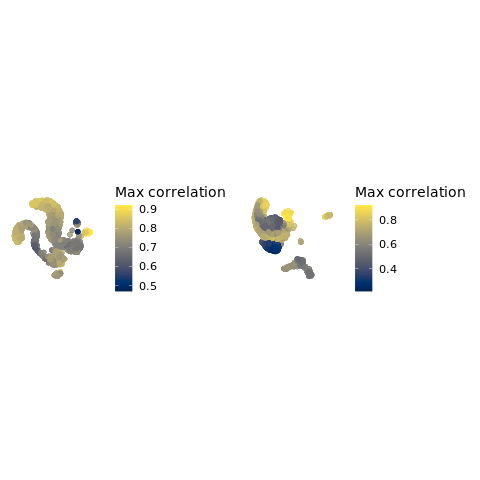

In [39]:
%%R

options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 300)

p1 <- plotNhoodMaxSim(t_milo, t_maxNhoods)
p2 <- plotNhoodMaxSim(o_milo, o_maxNhoods)
grid.arrange(p1,p2,nrow=1)

ggsave("compare_nhoods/intestine_analysis/tissue_oFSC_max_corr.pdf", p1, width=10, height=8, dpi=300)
ggsave("compare_nhoods/intestine_analysis/organoid_fsc_max_corr.pdf", p2, width=10, height=8, dpi=300)

In [40]:
# this step is to only get the colors
# celltypecols = organoid_gex.uns['level_2_late_colors']
celltypecols = tissue_latent.uns['Cell_type_colors']

In [41]:
%%R -i celltypecols

# print(celltypecols)
# names(celltypecols) <- unique(colData(o_milo)$level_2)

# highlight epithelial celltypes
# epi_cells = unique(t_milo$new_celltype[t_milo$big_cluster %in% c("C1",'C6')])
# t_milo$isEpi <- ifelse(t_milo$new_celltype %in% epi_cells,"Epithelial", "Non-Epithelial")




names(celltypecols) <- unique(colData(t_milo)$Cell_type)
p <- plotNhoodSimGroups(t_milo, t_maxNhoods$sim,  group_by="Cell_type",
#                         colour_by="isEpi",
                        xlabel="Correlation - FSC-derived organoids",
                        ylabel="Celltype (primary tissue)",size=0.15, 
                        group_colours=celltypecols, 
                        rel_min_height=0.001, show_rank = FALSE
                       )




# drop  celltype levels in empty nhoods
stat_summary <- table(p$data$group)
keep <- stat_summary > 5

p$data <- p$data[p$data$group %in% names(stat_summary)[keep],]
p$data$group <- droplevels(p$data$group)



p <- p + 
    scale_color_manual(values=c("orange","black")) + 
    theme(text = element_text(size=12),
          axis.text = element_text(size=20), 
          axis.text.y = element_text(size = 12),
          axis.ticks = element_line(size = 0.8),
          panel.grid.minor = element_line(size = 0.1), 
          panel.grid.major = element_line(size = 0.2)) 
p


ggsave("compare_nhoods/intestine_analysis/ridgeplot_intestine_primaryTissue_oFSC_nhoodCorr_ann_newcelltype.pdf", p, width=10, height=12, dpi=300)

Picking joint bandwidth of 0.0167
In addition: Warning message:
The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
